## MNIST digits generation with mini_torch 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from mini_torch import Conv2DTranspose, Tensor, Linear, sigmoid, Module, Adam, Conv2D, relu, binary_cross_entropy

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Helper function for sampling from N(0,1)
def sample_gaussian(mu, log_var):
    """Sample from N(mu, sigma) using reparameterization trick"""
    std = (log_var * Tensor(0.5)).exp()
    epsilon = Tensor(np.random.randn(*mu.shape))
    z = mu + std * epsilon
    return z

class VAE(Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder: 28x28 -> 14x14 -> 7x7
        self.conv1 = Conv2D(in_channels=1, out_channels=32, kernel_size=3, stride=2)   # (28,28) -> (13,13)
        self.conv2 = Conv2D(in_channels=32, out_channels=64, kernel_size=3, stride=2)  # (13,13) -> (6,6)
        self.conv3 = Conv2D(in_channels=64, out_channels=64, kernel_size=3, stride=1)  # (6,6) -> (4,4)
        
        # Latent space
        self.fc_mu = Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = Linear(64 * 4 * 4, latent_dim)
        
        # Decoder: latent -> 4x4 -> 7x7 -> 14x14 -> 28x28
        self.dec_fc = Linear(latent_dim, 64 * 4 * 4)
        self.deconv1 = Conv2DTranspose(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)  # 4x4 -> 6x6
        self.deconv2 = Conv2DTranspose(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0)  # 6x6 -> 13x13
        self.deconv3 = Conv2DTranspose(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=0)   # 13x13 -> 28x28
    
    def encode(self, x):
        """Encoder: x -> mu, log_var"""
        # x: (batch, 1, 28, 28)
        x = relu(self.conv1(x))   # (batch, 32, 13, 13)
        x = relu(self.conv2(x))   # (batch, 64, 6, 6)
        x = relu(self.conv3(x))   # (batch, 64, 4, 4)
        
        # Flatten
        x = x.reshape(x.shape[0], -1)  # (batch, 64*4*4)
        
        mu = self.fc_mu(x)         # (batch, latent_dim)
        log_var = self.fc_logvar(x)  # (batch, latent_dim)
        
        return mu, log_var
    
    def decode(self, z):
        """Decoder: z -> x_reconstructed"""
        # z: (batch, latent_dim)
        x = relu(self.dec_fc(z))  # (batch, 64*4*4)
        
        # Reshape to spatial dimensions
        x = x.reshape(x.shape[0], 64, 4, 4)  # (batch, 64, 4, 4)
        
        x = relu(self.deconv1(x))    # (batch, 64, 6, 6)
        x = relu(self.deconv2(x))    # (batch, 32, 13, 13)
        x = sigmoid(self.deconv3(x)) # (batch, 1, 28, 28)
        
        return x
    
    def forward(self, x):
        """Forward pass: encode, sample, decode"""
        mu, log_var = self.encode(x)
        z = sample_gaussian(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

def vae_loss(x_recon, x, mu, log_var):
    """
    VAE loss = Reconstruction loss + KL divergence
    
    Reconstruction loss: Binary cross entropy
    KL divergence: KL(N(mu, sigma) || N(0, 1))
    """
    # Reconstruction loss (binary cross entropy)
    recon_loss = binary_cross_entropy(x_recon, x)
    
    # KL divergence: -0.5 * sum(1 + log_var - mu^2 - exp(log_var))
    kl_term = Tensor(1.0) + log_var - mu.pow(2) - log_var.exp()
    kl_loss = (Tensor(-0.5) * kl_term).sum()
    
    return recon_loss + kl_loss, recon_loss, kl_loss

# Initialize model
latent_dim = 20
model = VAE(latent_dim=latent_dim)
optimizer = Adam(model.parameters(), lr=0.001)



In [9]:
# Training loop
num_epochs = 10
print("Training VAE...")
print("=" * 60)

for epoch in range(num_epochs):
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    
    for batch_idx, (images, _) in enumerate(train_loader):
        # Forward pass
        x = Tensor(images.numpy())
        x_recon, mu, log_var = model(x)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(x_recon, x, mu, log_var)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        total_recon += recon_loss.data
        total_kl += kl_loss.data
        
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} [{batch_idx}/{len(train_loader)}] "
                  f"Loss: {loss.data:.4f} (Recon: {recon_loss.data:.4f}, KL: {kl_loss.data:.4f})")
    
    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Avg Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KL: {avg_kl:.4f})\n")

print("=" * 60)
print("Training complete!")



Training VAE...
Epoch 1/10 [0/469] Loss: 69594.0547 (Recon: 69555.0547, KL: 39.0006)
Epoch 1/10 [100/469] Loss: 27849.3164 (Recon: 26218.3535, KL: 1630.9630)
Epoch 1/10 [200/469] Loss: 20870.4824 (Recon: 18435.5234, KL: 2434.9590)
Epoch 1/10 [300/469] Loss: 17862.4609 (Recon: 14234.2988, KL: 3628.1616)
Epoch 1/10 [400/469] Loss: 16038.3340 (Recon: 12186.7686, KL: 3851.5654)

Epoch 1/10 Summary:
  Avg Loss: 23357.0264 (Recon: 20520.6312, KL: 2836.3952)

Epoch 2/10 [0/469] Loss: 15052.2617 (Recon: 10984.1055, KL: 4068.1567)
Epoch 2/10 [100/469] Loss: 14333.2607 (Recon: 10118.9180, KL: 4214.3428)
Epoch 2/10 [200/469] Loss: 13565.3535 (Recon: 9495.4746, KL: 4069.8784)
Epoch 2/10 [300/469] Loss: 13957.7412 (Recon: 9628.3262, KL: 4329.4150)
Epoch 2/10 [400/469] Loss: 14290.8428 (Recon: 9946.1250, KL: 4344.7178)

Epoch 2/10 Summary:
  Avg Loss: 14505.7321 (Recon: 10275.7705, KL: 4229.9615)

Epoch 3/10 [0/469] Loss: 13967.8516 (Recon: 9689.1172, KL: 4278.7344)
Epoch 3/10 [100/469] Loss: 13782.


Generating samples from latent space...

Reconstrucing test images...


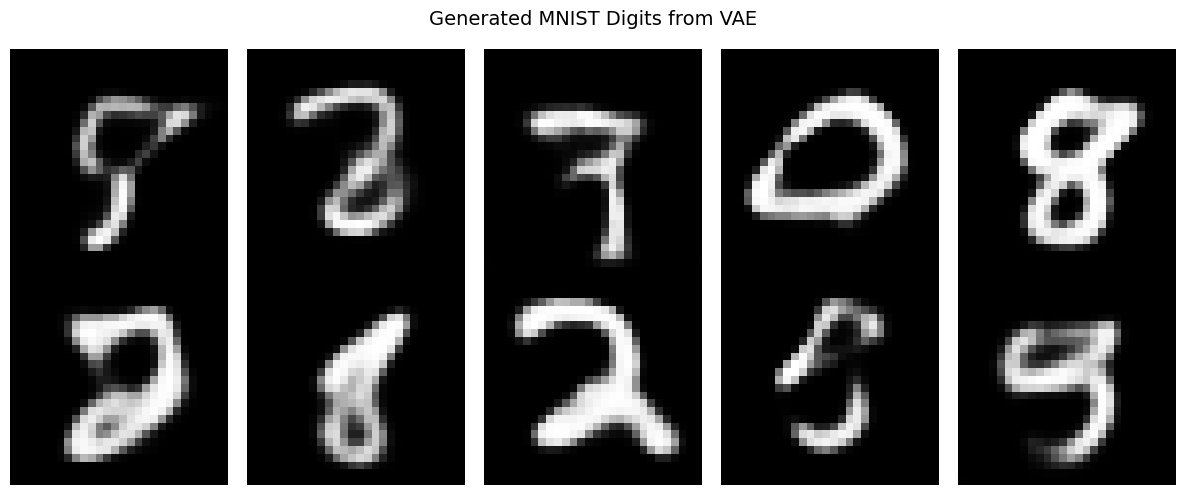

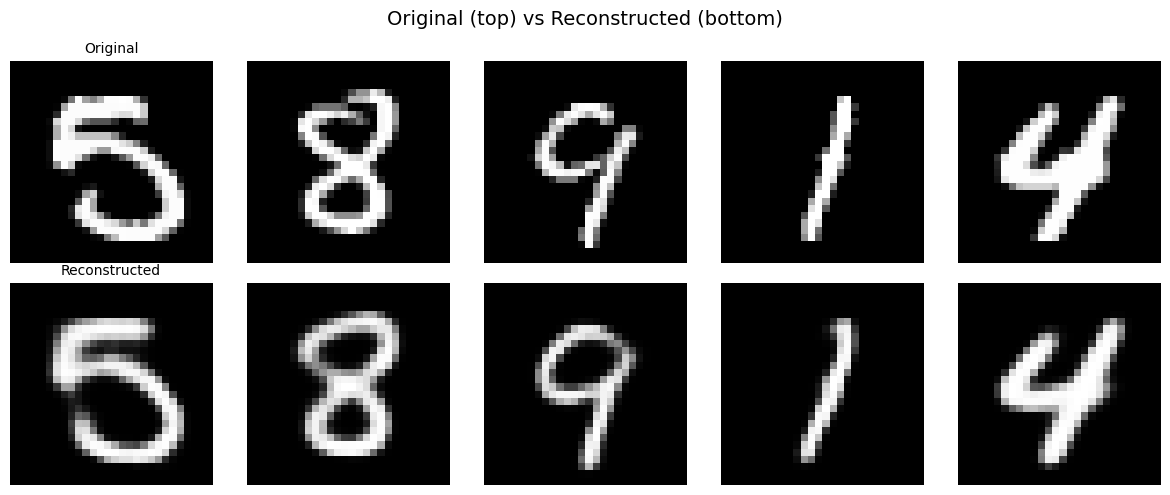


Done!


In [14]:
# Generate new samples
print("\nGenerating samples from latent space...")
n_samples = 10
z_samples = Tensor(np.random.randn(n_samples, latent_dim).astype(np.float32))
generated = model.decode(z_samples)

# Visualize generated samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Generated MNIST Digits from VAE', fontsize=14)

for i, ax in enumerate(axes.flat):
    img = generated.data[i, 0]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
#plt.savefig('vae_generated_digits.png', dpi=150, bbox_inches='tight')
#print("Generated samples saved as 'vae_generated_digits.png'")

# Reconstruct some real images
print("\nReconstrucing test images...")
test_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_images, _ = next(iter(test_loader))
test_x = Tensor(test_images.numpy())
test_recon, _, _ = model(test_x)

# Visualize reconstructions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Original (top) vs Reconstructed (bottom)', fontsize=14)

for i in range(5):
    # Original
    axes[0, i].imshow(test_images[i, 0].numpy(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10)
    
    # Reconstructed
    axes[1, i].imshow(test_recon.data[i, 0], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=10)

plt.tight_layout()
#plt.savefig('vae_reconstructions.png', dpi=150, bbox_inches='tight')
#print("Reconstructions saved as 'vae_reconstructions.png'")
plt.show()

print("\nDone!")